In [91]:
import sys
import logging
from surface import SurfaceWrapper
import multiprocessing
import os
import time
from collections import OrderedDict
from glob import glob

import click
from matplotlib import pyplot as plt
import matplotlib.gridspec as gs
import numpy as np
from spectral.io import envi
from scipy.optimize import least_squares
import scipy

from isofit import ray
from isofit.configs import configs
from isofit.core.common import envi_header, load_spectrum, svd_inv_sqrt
from isofit.core.common import conditional_gaussian, eps
from isofit.core.fileio import IO, write_bil_chunk
from isofit.core.forward import ForwardModel
from isofit.core.geometry import Geometry
from isofit.inversion.inverse import Inversion
from isofit.inversion.inverse_simple import invert_analytical
from isofit.inversion.inverse_simple import invert_simple
from isofit.radiative_transfer.radiative_transfer import RadiativeTransfer
from isofit.radiative_transfer import luts

import jax
jax.config.update('jax_num_cpu_devices', 15)

import jax.numpy as jnp
from jax.sharding import PartitionSpec as P
from jax import tree_util
import jax.scipy.optimize as jopt
import jaxopt
# import optax

from rte import RTEcalc, build_interpolators, VectorInterpolator, calc_rdn, RTEparams
from surface import SurfaceParams, SurfaceWrapper

In [92]:
def lut_grid(lut, lut_names):
    wl = lut.wl.data
    points = np.array([[point[0], point[1]] for point in lut.point.data])

    # Initialize arrays
    lut = lut.unstack("point")
    lut = lut.transpose(*lut_names, "wl")
    rhoatm = lut['rhoatm'].load().data
    sphalb = lut['sphalb'].load().data
    transm_down_dir = lut['transm_down_dir'].load().data
    transm_down_dif = lut['transm_down_dif'].load().data
    transm_up_dir = lut['transm_up_dir'].load().data
    transm_up_dif = lut['transm_up_dif'].load().data
    dir_dir = lut['dir-dir'].load().data
    dir_dif = lut['dir-dif'].load().data
    dif_dir = lut['dif-dir'].load().data
    dif_dif = lut['dif-dif'].load().data
    #return {'sphalb': sphalb, 'transm': transm, 'rhoatm': rhoatm}

    jpoints = tuple((np.unique(points[:, 0]), np.unique(points[:, 1])))
    int_rhoatm = jax.scipy.interpolate.RegularGridInterpolator(
        jpoints, 
        jnp.array(rhoatm), 
        method='linear'
    )
    int_sphalb = jax.scipy.interpolate.RegularGridInterpolator(
        jpoints, 
        jnp.array(sphalb), 
        method='linear'
    )
    int_transm_down_dir = jax.scipy.interpolate.RegularGridInterpolator(
        jpoints, 
        jnp.array(transm_down_dir), 
        method='linear'
    )
    int_transm_down_dif = jax.scipy.interpolate.RegularGridInterpolator(
        jpoints, 
        jnp.array(transm_down_dif), 
        method='linear'
    )
    int_transm_up_dir = jax.scipy.interpolate.RegularGridInterpolator(
        jpoints, 
        jnp.array(transm_up_dir), 
        method='linear'
    )
    int_transm_up_dif = jax.scipy.interpolate.RegularGridInterpolator(
        jpoints, 
        jnp.array(transm_up_dif), 
        method='linear'
    )
    int_dir_dir = jax.scipy.interpolate.RegularGridInterpolator(
        jpoints, 
        jnp.array(dir_dir), 
        method='linear'
    )
    int_dir_dif = jax.scipy.interpolate.RegularGridInterpolator(
        jpoints, 
        jnp.array(dir_dif), 
        method='linear'
    )
    int_dif_dir = jax.scipy.interpolate.RegularGridInterpolator(
        jpoints, 
        jnp.array(dif_dir), 
        method='linear'
    )
    int_dif_dif = jax.scipy.interpolate.RegularGridInterpolator(
        jpoints, 
        jnp.array(dif_dif), 
        method='linear'
    )

    return {
        'rhoatm': int_rhoatm,
        'sphalb': int_sphalb, 
        'transm_down_dir': int_transm_down_dir,
        'transm_down_dif': int_transm_down_dif,
        'transm_up_dir': int_transm_down_dir,
        'transm_up_dif': int_transm_down_dir,
        'dir_dir': int_dir_dir,
        'dir_dif': int_dir_dif,
        'dif_dir': int_dir_dir,
        'dif_dif': int_dir_dif,
    }

In [93]:
@jax.jit
def calc_rdn(x_surface, x_RT, L, lut_dict):
    
    L_down_dir = L * lut_dict['transm_down_dir'](x_RT)
    L_down_dif = L * lut_dict['transm_down_dif'](x_RT)
    L_up_dir = L * lut_dict['transm_up_dir'](x_RT)
    L_up_dif = L * lut_dict['transm_up_dif'](x_RT)

    L_dir_dir = L_down_dir * L_up_dir / (coszen * cos_i)
    L_dif_dir = L_down_dif * L_up_dir
    L_dir_dif = L_down_dir * L_up_dif / (coszen * cos_i)
    L_dif_dif = L_down_dif * L_up_dif 

    L_atm = (solar_irr * coszen) / jnp.pi * lut_dict["rhoatm"](x_RT)
    sphalb = lut_dict["sphalb"](x_RT)

    rfl = x_surface

    L_tot = L_dir_dir + L_dif_dir + L_dir_dif + L_dif_dif
    # TOA radiance model
    return (
        L_atm
        + L_dir_dir * rfl
        + L_dif_dir * rfl
        + L_dir_dif * rfl
        + L_dif_dif * rfl
        + (L_tot * sphalb * rfl * rfl) / (1 - sphalb * rfl)
    )

In [94]:
def loss_function(x, meas, L, nwl, lut_dict):

    est_meas = calc_rdn(
        x.at[:nwl].get(),
        x.at[nwl:].get(),
        L,
        lut_dict
    )

    resid = (
        est_meas - meas
    )**2

    return jnp.sum(resid)

In [95]:
# Load config, fm
config_file = '/Users/bgreenbe/Projects/IsofitDev/RTandGlintTests/Water/PriorTests/Prior7/config/emit20240814T104137_isofit.json'
config =  configs.create_new_config(config_file)
fm = ForwardModel(config)
iv = Inversion(config, fm)
wl = jnp.array(fm.RT.wl)

In [96]:
# Load data
esd = IO.load_esd()
in_root = '/Users/bgreenbe/Projects/IsofitDev/RTandGlintTests/Water/PriorTests/Sample1'
sub_root = '/Users/bgreenbe/Projects/IsofitDev/RTandGlintTests/Water/PriorTests/Prior7/input'
out_root = '/Users/bgreenbe/Projects/IsofitDev/RTandGlintTests/Water/PriorTests/Prior7/output'

obs = envi.open(envi_header(os.path.join(
    in_root, 'emit20240814T104137_obs'
)))
obs_im = obs.open_memmap(interleave="bip")

loc = envi.open(envi_header(os.path.join(
    in_root, 'emit20240814T104137_loc'
)))
loc_im = loc.open_memmap(interleave="bip")

rdn = envi.open(envi_header(os.path.join(
    in_root, 'emit20240814T104137_rdn'
)))
rdn_im = rdn.open_memmap(interleave="bip")

sub_obs = envi.open(envi_header(os.path.join(
    sub_root, 'emit20240814T104137_subs_obs'
)))
sub_obs_im = sub_obs.open_memmap(interleave="bip")

sub_loc = envi.open(envi_header(os.path.join(
    sub_root, 'emit20240814T104137_subs_loc'
)))
sub_loc_im = sub_loc.open_memmap(interleave="bip")

sub_rdn = envi.open(envi_header(os.path.join(
    sub_root, 'emit20240814T104137_subs_rdn'
)))
sub_rdn_im = sub_rdn.open_memmap(interleave="bip")

lbl = envi.open(envi_header(os.path.join(
    out_root,
    'emit20240814T104137_lbl'
)))
lbl_im = lbl.open_memmap(interleave="bip")

atm= envi.open(envi_header(os.path.join(
    out_root,
    'emit20240814T104137_atm_interp'
)))
atm_im = atm.open_memmap(interleave="bip")

In [97]:
# Sample point
r, c = [200, 100]
sr = int(lbl_im[r, c])
sub_meas = sub_rdn_im[sr, 0, :]
sub_geom = Geometry(
    obs=sub_obs_im[sr, 0, :], 
    loc=sub_loc_im[sr, 0, :], 
    esd=esd
)
meas = rdn_im[r, c, :]
geom = Geometry(
    obs=obs_im[r, c, :], 
    loc=loc_im[r, c, :], 
    esd=esd
)

/var/folders/rl/99sjlfcs4ql0f2xqyzd7z0nw0000gq/T/ipykernel_66225/1074907614.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sr = int(lbl_im[r, c])


In [98]:
# Set up LUT
rt = RadiativeTransfer(config)
rte = rt.rt_engines[0]
lut = rte.lut
lut_names = rt.rt_engines[0].lut_names
lut_dict = lut_grid(lut, lut_names)

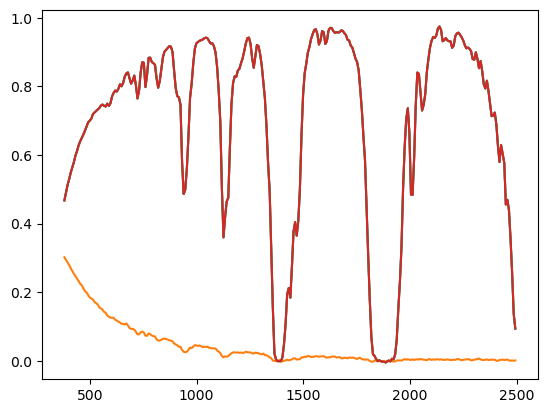

In [99]:
# Gut check lUT
x = fm.init
x_surface, x_RT, x_instrument = fm.unpack(x)

# In transm mode
transm_down_dir = lut_dict['transm_down_dir'](x_RT)[0, :]
transm_down_dif = lut_dict['transm_down_dif'](x_RT)[0, :]
transm_up_dir = lut_dict['transm_up_dir'](x_RT)[0, :]
transm_up_dif = lut_dict['transm_up_dif'](x_RT)[0, :]

plt.plot(wl, transm_down_dir)
plt.plot(wl, transm_down_dif)
plt.plot(wl, transm_up_dir)
plt.plot(wl, transm_up_dif)

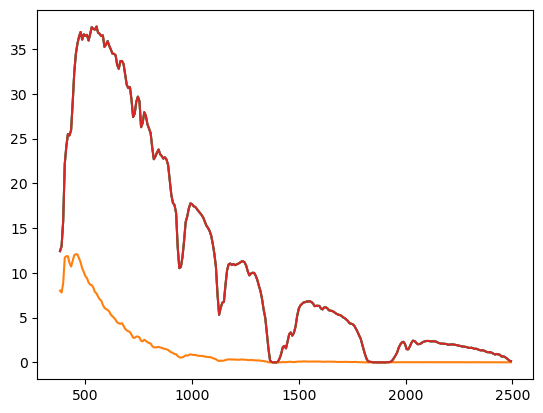

In [100]:
# Get static geoms irr scalers and vectors
coszen, cos_i = geom.check_coszen_and_cos_i(rte.coszen)
solar_irr = fm.RT.solar_irr
L = solar_irr * coszen / np.pi 

# Gut check LUT in rdn
rdn_down_dir = L * transm_down_dir
rdn_down_dif = L * transm_down_dif
rdn_up_dir = L * transm_up_dir
rdn_up_dif = L * transm_up_dif

plt.plot(wl, rdn_down_dir)
plt.plot(wl, rdn_down_dif)
plt.plot(wl, rdn_up_dir)
plt.plot(wl, rdn_up_dif)

JAX H2O grad: -173014016.0
Isofit H2O grad: 0.013509132904939188


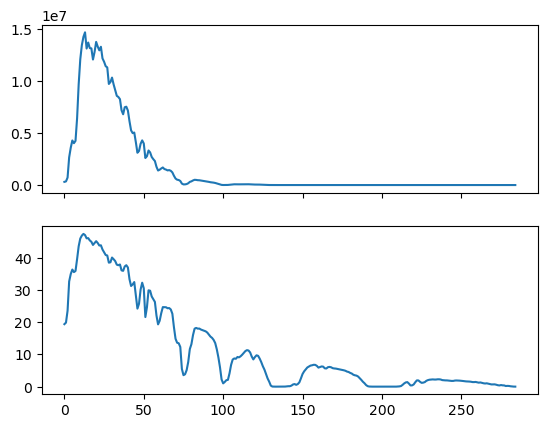

In [101]:
# JIT loss function
jloss = jax.jit(loss_function, static_argnums=[3])

# Check grads at init
x = fm.init
loss, grad = jax.value_and_grad(jloss)(
    x, meas, L, len(wl), lut_dict
)

# JAX gradients looking funky
fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].plot(grad[:len(wl)])
axs[1].plot(np.diag(fm.K(x, geom)))

print(f'JAX H2O grad: {grad[-2]}')
print(f'Isofit H2O grad: {np.diag(fm.K(x, geom))[-2]}')

/Users/bgreenbe/micromamba/envs/isofit_env/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:6184: UserWarning: Explicitly requested dtype float64 requested in eye is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  output = _eye(N, M=M, k=k, dtype=dtype)
/Users/bgreenbe/micromamba/envs/isofit_env/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:122: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


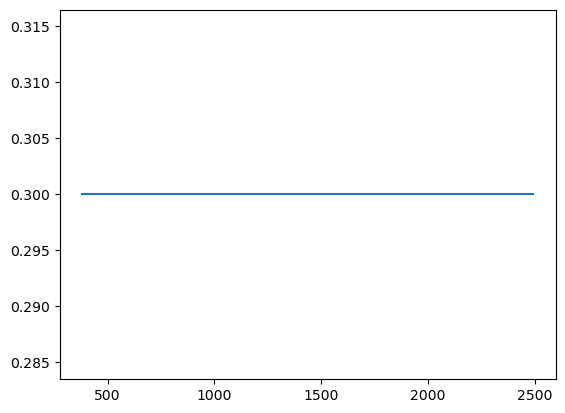

In [102]:
# Example inversion
res = jopt.minimize(
    jloss,
    x,
    (
       jnp.array(meas), 
       jnp.array(L),
       len(wl), 
       lut_dict
    ),
    method='BFGS'
)

plt.plot(wl, res.x[:len(wl)])
plt.show()

In [88]:
# Examine the sgd trajectory
learning_rate = 0.0001

x = fm.init
xs = []
grads = []
xs.append(x)
grads.append([0 for i in x])

for i in range(5):
    loss, grad = jax.value_and_grad(jloss)(
        x, meas, L, len(wl), lut_dict
    )
    print(f'Loss: {loss}')
    x -= learning_rate * grad
    xs.append(x)
    grads.append(grad)


Loss: 68097040.0
Loss: nan
Loss: nan
Loss: nan
Loss: nan


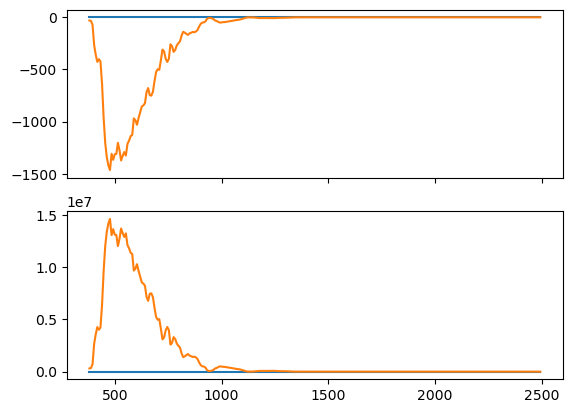

In [87]:
# Exploding gradients...
fig, axs = plt.subplots(2, 1, sharex=True)
for i in range(len(xs)):
    axs[0].plot(wl, xs[i][:len(wl)])
    axs[1].plot(wl, grads[i][:len(wl)])

In [104]:
# Try seeding the jax inversion with the OE inversion
learning_rate = 0.0001

x = np.squeeze(iv.invert(meas, geom)[-1])
xs = []
grads = []
xs.append(x)
grads.append([0 for i in x])

for i in range(5):
    loss, grad = jax.value_and_grad(jloss)(
        x, meas, L, len(wl), lut_dict
    )
    print(f'Loss: {loss}')
    x -= learning_rate * grad
    xs.append(x)
    grads.append(grad)

Loss: 6081.32275390625
Loss: nan
Loss: nan
Loss: nan
Loss: nan
